### Project Datmod

In [2]:
from pathlib import Path

dataset_path = Path("C:/Users/ardo/Downloads/Dataset Datmod")

for item in dataset_path.iterdir():
    print(item)

C:\Users\ardo\Downloads\Dataset Datmod\.ipynb_checkpoints
C:\Users\ardo\Downloads\Dataset Datmod\recording_location.txt
C:\Users\ardo\Downloads\Dataset Datmod\sample_submission.csv
C:\Users\ardo\Downloads\Dataset Datmod\taxonomy.csv
C:\Users\ardo\Downloads\Dataset Datmod\test_soundscapes
C:\Users\ardo\Downloads\Dataset Datmod\train.csv
C:\Users\ardo\Downloads\Dataset Datmod\train_audio
C:\Users\ardo\Downloads\Dataset Datmod\train_soundscapes
C:\Users\ardo\Downloads\Dataset Datmod\Untitled.ipynb


### EDA

In [53]:
import pandas as pd
df = pd.read_csv("train.csv")
print(df.head(10))
print("\nKolom yang tersedia:")
print(df.columns)

  primary_label              secondary_labels                    type  \
0       1139490                          ['']                    ['']   
1       1139490                          ['']                    ['']   
2       1192948                          ['']                    ['']   
3       1192948                          ['']                    ['']   
4       1192948                          ['']                    ['']   
5       1192948                          ['']                    ['']   
6       1194042                          ['']                    ['']   
7       1194042                          ['']                    ['']   
8       1194042                          ['']                    ['']   
9        126247  ['65448', '22976', '476538']  ['advertisement call']   

               filename collection  rating  \
0  1139490/CSA36385.ogg        CSA     0.0   
1  1139490/CSA36389.ogg        CSA     0.0   
2  1192948/CSA36358.ogg        CSA     0.0   
3  1192948/C

Statistik Deskriptif:
             rating      latitude     longitude
count  28564.000000  27755.000000  27755.000000
mean       2.917063     -0.533480    -68.524380
std        1.964896     17.609276     21.614566
min        0.000000    -54.857400   -163.680000
25%        0.000000    -15.084600    -79.649200
50%        4.000000      1.131600    -73.495400
75%        4.500000      9.511000    -53.801800
max        5.000000     68.374800    153.551400


C:\Users\jayas\AppData\Local\Temp\ipykernel_23616\3419720181.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_labels.index, x=top_labels.values, palette="viridis")


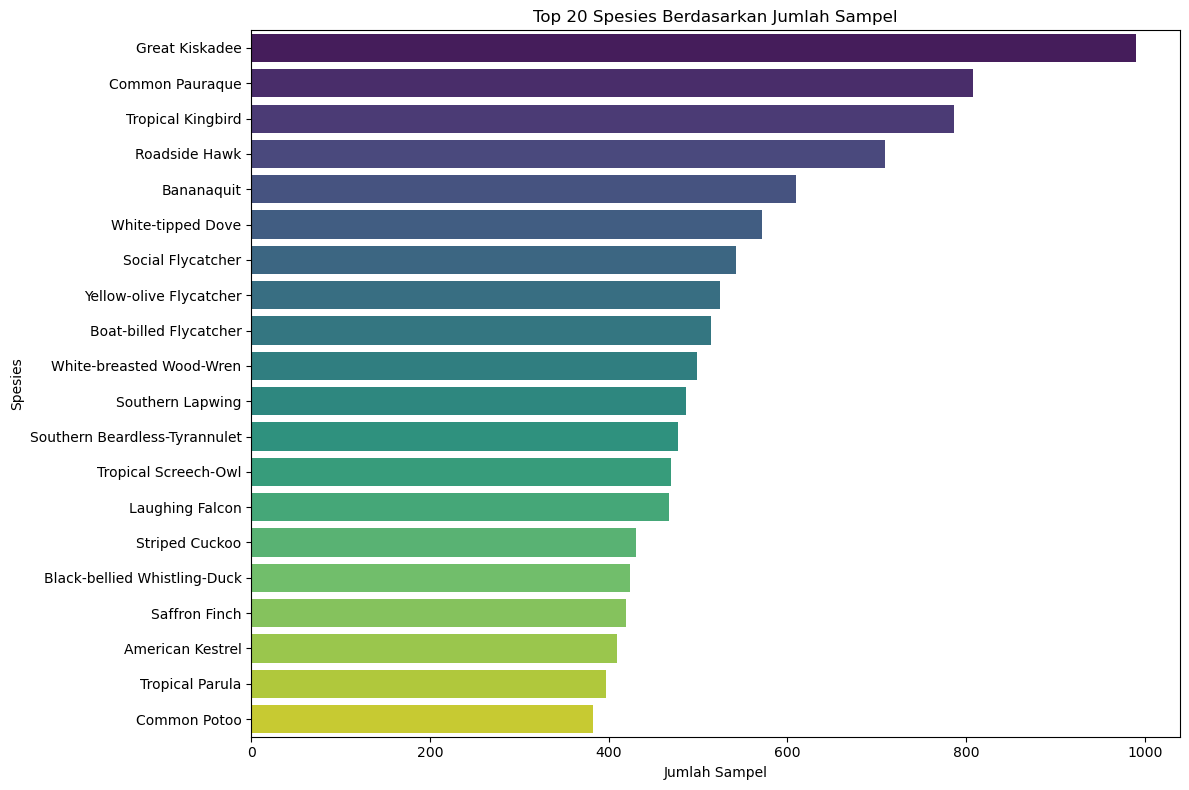

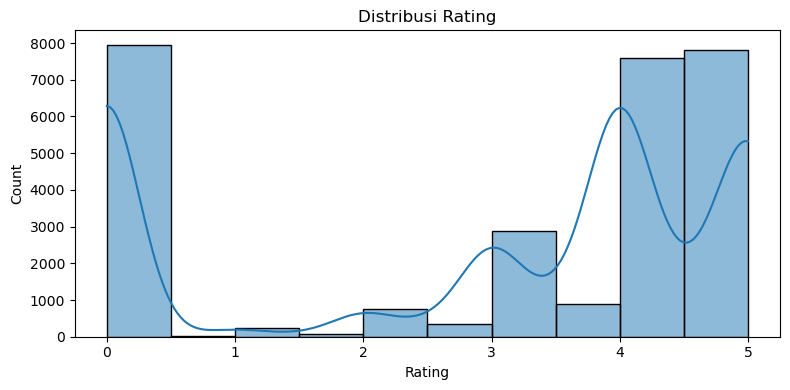

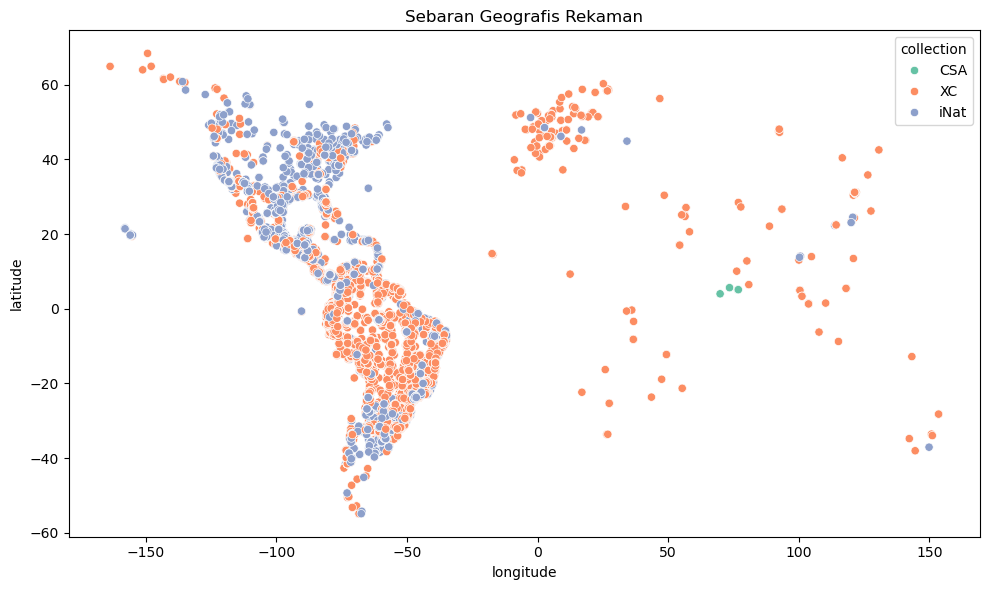

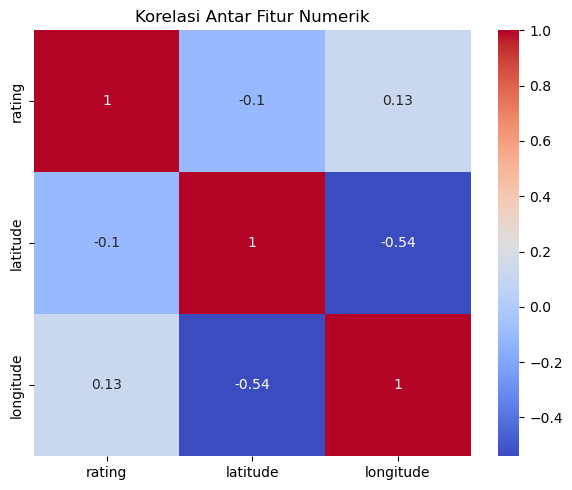


Jumlah Outliers:
rating: 0
latitude: 223
longitude: 434


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Statistik Deskriptif:")
print(df[["rating", "latitude", "longitude"]].describe())

plt.figure(figsize=(12, 8))
top_labels = df["common_name"].value_counts().head(20)
sns.barplot(y=top_labels.index, x=top_labels.values, palette="viridis")
plt.title("Top 20 Spesies Berdasarkan Jumlah Sampel")
plt.xlabel("Jumlah Sampel")
plt.ylabel("Spesies")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df["rating"], bins=10, kde=True)
plt.title("Distribusi Rating")
plt.xlabel("Rating")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="longitude", y="latitude", hue="collection", palette="Set2")
plt.title("Sebaran Geografis Rekaman")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
corr = df[["rating", "latitude", "longitude"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Korelasi Antar Fitur Numerik")
plt.tight_layout()
plt.show()

def detect_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    return outliers

print("\nJumlah Outliers:")
for col in ["rating", "latitude", "longitude"]:
    print(f"{col}: {detect_outliers(col)}")

### Cleaning

In [57]:
df_clean = df[df["rating"] > 0].copy()
df_clean = df_clean.drop_duplicates(subset=["filename"])

print(f"Jumlah data setelah dibersihkan: {len(df_clean)}")

Jumlah data setelah dibersihkan: 20616


### Install librosa untuk extract audio

In [7]:
pip install librosa

   ---------------------------------------- 0.0/260.7 kB ? eta -:--:--
   - -------------------------------------- 10.2/260.7 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/260.7 kB 640.0 kB/s eta 0:00:01
   ---- ---------------------------------- 30.7/260.7 kB 640.0 kB/s eta 0:00:01
   ------ -------------------------------- 41.0/260.7 kB 217.9 kB/s eta 0:00:02
   ------------- ------------------------- 92.2/260.7 kB 401.6 kB/s eta 0:00:01
   ---------------- --------------------- 112.6/260.7 kB 467.6 kB/s eta 0:00:01
   ----------------- -------------------- 122.9/260.7 kB 399.4 kB/s eta 0:00:01
   ----------------------------- -------- 204.8/260.7 kB 565.6 kB/s eta 0:00:01
   -------------------------------------- 260.7/260.7 kB 668.0 kB/s eta 0:00:00
   ---------------------------------------- 0.0/64.6 kB ? eta -:--:--
   ---------------------------------------- 64.6/64.6 kB 3.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--


In [59]:
import librosa
import numpy as np
from tqdm import tqdm
import os
audio_base_path = "C:/Users/jayas/Documents/Project Datmod/birdclef-2025/train_audio"
def extract_mfcc(file_path, n_mfcc=13, duration=5, sr=22050):
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        return mfcc.mean(axis=1)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return np.zeros(n_mfcc)
features = []
labels = []

for i, row in tqdm(df_clean.iterrows(), total=len(df_clean)):
    path = os.path.join(audio_base_path, row["filename"])
    mfcc = extract_mfcc(path)
    features.append(mfcc)
    labels.append(row["common_name"])
X = np.array(features)
y = np.array(labels)

print("Shape fitur MFCC:", X.shape)

100%|████████████████████████████████████████████████████████████████████████████| 20616/20616 [03:32<00:00, 97.03it/s]

Shape fitur MFCC: (20616, 13)


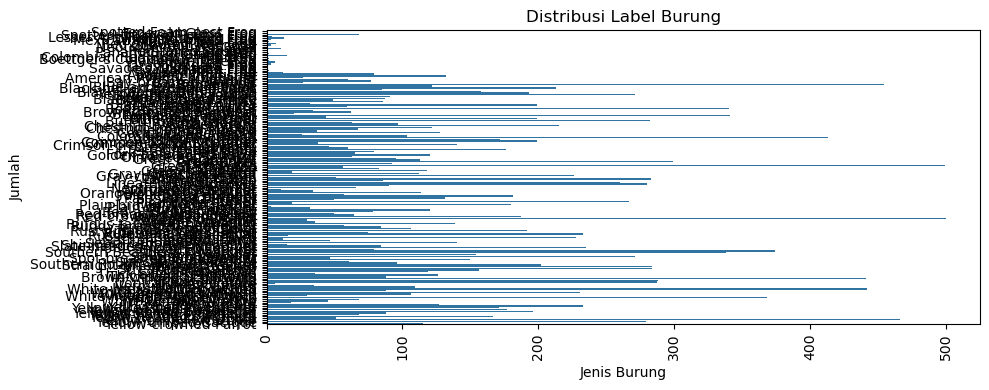

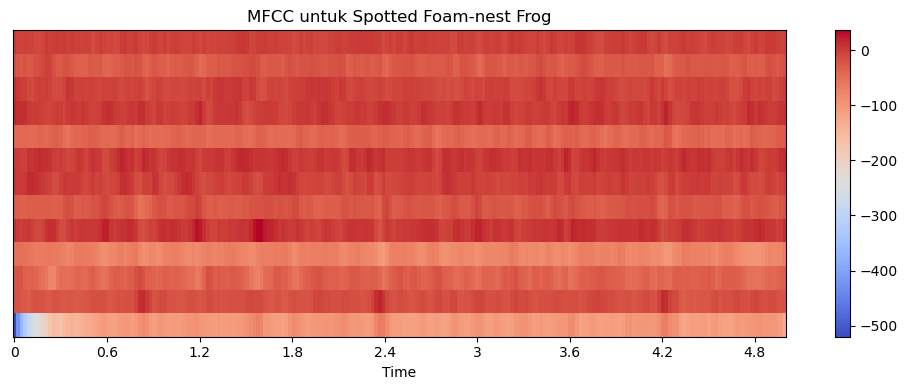

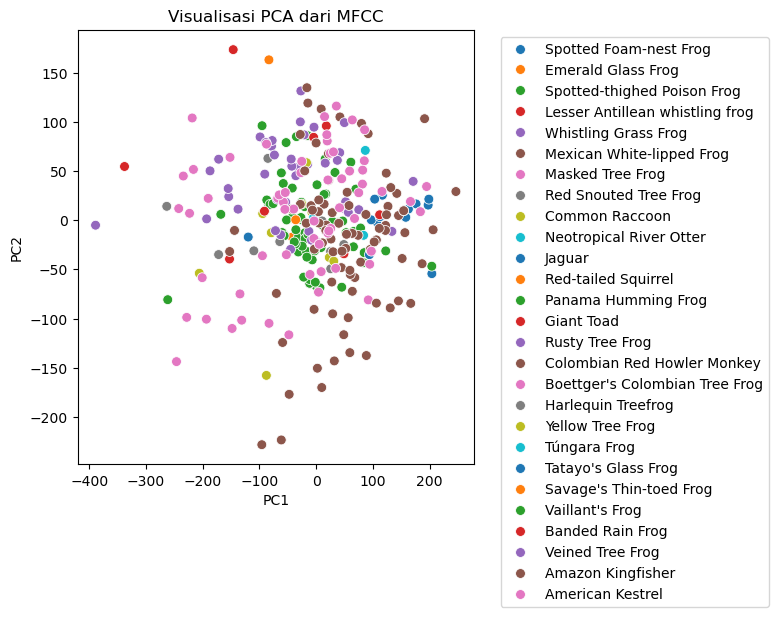

C:\Users\jayas\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


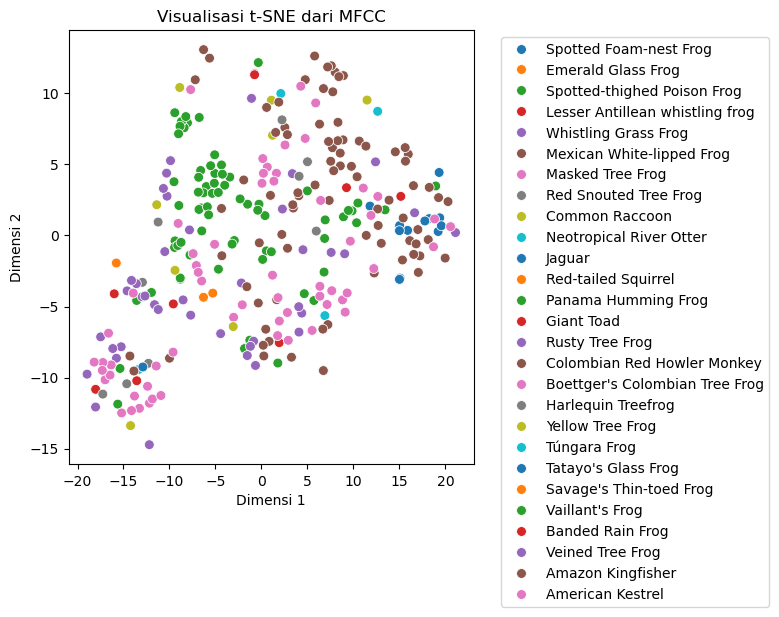

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

# 1. Distribusi label
plt.figure(figsize=(10, 4))
sns.countplot(y)
plt.xticks(rotation=90)
plt.title("Distribusi Label Burung")
plt.xlabel("Jenis Burung")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

# 2. Visualisasi MFCC untuk satu audio
example_file = os.path.join(audio_base_path, df_clean["filename"].iloc[0])
audio, sr = librosa.load(example_file, sr=22050, duration=5)
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar()
plt.title(f"MFCC untuk {df_clean['common_name'].iloc[0]}")
plt.tight_layout()
plt.show()

# 3. Visualisasi sebaran data MFCC menggunakan PCA & TSNE
# (ambil sample kecil agar proses cepat)
sample_size = min(300, len(X))
X_sample = X[:sample_size]
y_sample = y[:sample_size]

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_sample, palette='tab10', s=50)
plt.title("Visualisasi PCA dari MFCC")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# TSNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_sample, palette='tab10', s=50)
plt.title("Visualisasi t-SNE dari MFCC")
plt.xlabel("Dimensi 1")
plt.ylabel("Dimensi 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [63]:
import pandas as pd

label_counts = pd.Series(labels).value_counts()
valid_labels = label_counts[label_counts >= 2].index
filtered_indices = [i for i, label in enumerate(labels) if label in valid_labels]
X_filtered = X[filtered_indices]
y_filtered = np.array([labels[i] for i in filtered_indices])

In [65]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Misalnya X_filtered dan y_filtered sudah didefinisikan sebelumnya
# Tambahan: filter label dengan jumlah >= 2
filtered_mask = pd.Series(y_filtered).map(pd.Series(y_filtered).value_counts()) >= 2
X_filtered = X_filtered[filtered_mask]
y_filtered = y_filtered[filtered_mask]

# Label Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")


Train shape: (16485, 13), Validation shape: (4122, 13)


In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Pastikan numpy diimpor

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))

# Pastikan jumlah label dan target_names sinkron
unique_labels = np.unique(y_val)
target_names = le.inverse_transform(unique_labels)

print("\nClassification Report:\n", classification_report(y_val, y_pred, labels=unique_labels, target_names=target_names))


Accuracy: 0.14095099466278505

Classification Report:
                                  precision    recall  f1-score   support

              Amazon Kingfisher       0.00      0.00      0.00        16
               American Kestrel       0.21      0.15      0.18        26
      American Pygmy Kingfisher       0.00      0.00      0.00         5
                        Anhinga       0.33      0.17      0.22        12
                     Bananaquit       0.15      0.45      0.23        91
                Bare-faced Ibis       0.25      0.20      0.22         5
           Bay-breasted Warbler       0.00      0.00      0.00        15
                 Bicolored Wren       0.36      0.24      0.29        17
                  Black Vulture       0.12      0.08      0.10        12
   Black-bellied Whistling-Duck       0.23      0.19      0.21        43
             Black-bellied Wren       0.25      0.06      0.09        18
        Black-capped Donacobius       0.22      0.12      0.16      

C:\Users\jayas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jayas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jayas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [69]:
df['label'] = df['scientific_name'].astype('category').cat.codes
label_names = df['scientific_name'].astype('category').cat.categories.tolist()

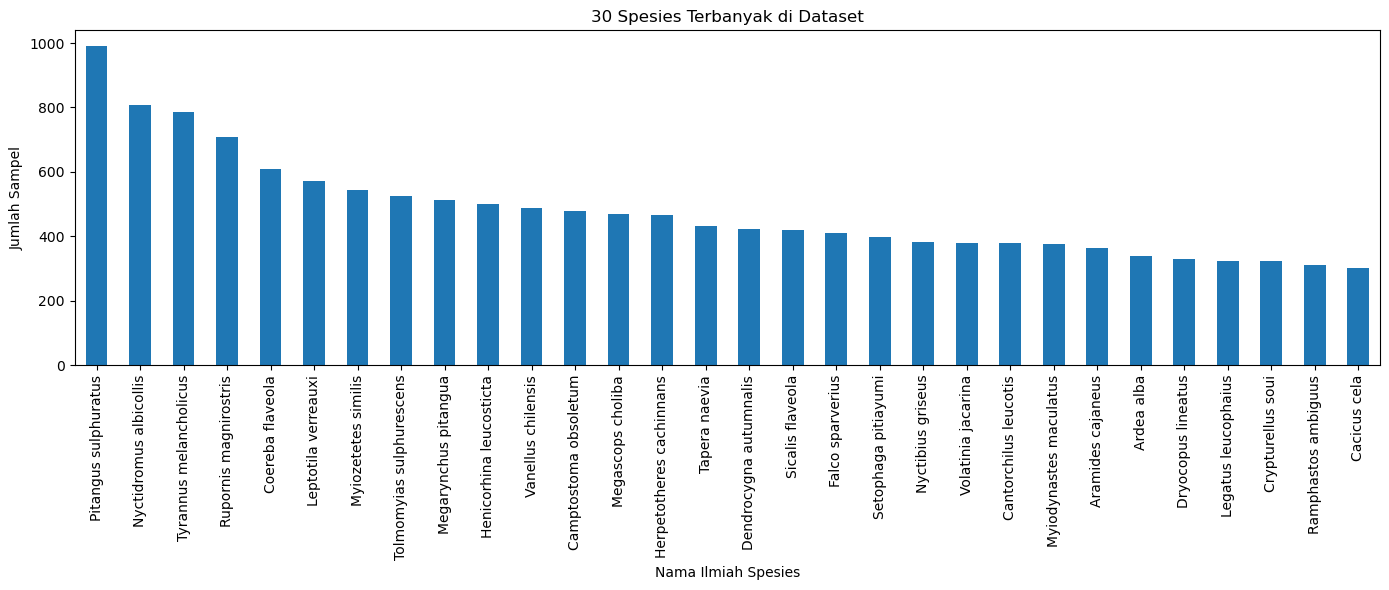

In [71]:
import matplotlib.pyplot as plt

species_counts = df['scientific_name'].value_counts()

plt.figure(figsize=(14, 6))
species_counts.head(30).plot(kind='bar')
plt.title('30 Spesies Terbanyak di Dataset')
plt.xlabel('Nama Ilmiah Spesies')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

##### lanjut ke file audio

In [73]:
import librosa
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

In [75]:
audio_dir = r'C:/Users/jayas/Documents/Project Datmod/birdclef-2025/train_audio'
subset_df = df.sample(100, random_state=42)

mfcc_features = []
labels = []

for idx, row in tqdm(subset_df.iterrows(), total=len(subset_df)):
    file_path = os.path.join(audio_dir, row['filename'])

    try:
        y, sr = librosa.load(file_path, sr=None)
        y = y[:5*sr]
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc_mean = np.mean(mfcc.T, axis=0)

        mfcc_features.append(mfcc_mean)
        labels.append(row['label'])
    except Exception as e:
        print(f"Gagal memproses {file_path}: {e}")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.98it/s]


In [77]:
X = np.array(mfcc_features)
y = np.array(labels)

print("Shape fitur:", X.shape)
print("Jumlah label:", len(y))

Shape fitur: (100, 20)
Jumlah label: 100


In [79]:
label_counts = df['primary_label'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
df_filtered = df[df['primary_label'].isin(valid_labels)]
X = df_filtered.drop(['primary_label'], axis=1)
y = df_filtered['primary_label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Jumlah label unik setelah filter:", y.nunique())
print("Ukuran X_train:", X_train.shape)

Jumlah label unik setelah filter: 206
Ukuran X_train: (22851, 13)


In [81]:
selected_features = ['latitude', 'longitude', 'rating']

X = df_clean[selected_features]
y = df_clean['primary_label']

In [83]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df_filtered[selected_features])
y = df_filtered['primary_label']
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, stratify=y, random_state=42
)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.19411867670225802
Classification Report:
               precision    recall  f1-score   support

     1192948       1.00      1.00      1.00         1
     1194042       0.00      0.00      0.00         1
      126247       0.00      0.00      0.00         1
     1346504       0.00      0.00      0.00         1
      134933       1.00      1.00      1.00         1
      135045       0.67      1.00      0.80         2
     1462711       0.00      0.00      0.00         1
     1462737       0.00      0.00      0.00         1
     1564122       0.20      1.00      0.33         1
       21211       0.56      0.67      0.61        15
       22333       0.50      0.44      0.47         9
       22973       0.31      0.36      0.33        11
       22976       0.11      0.11      0.11         9
       24272       0.00      0.00      0.00         1
       24292       1.00      1.00      1.00         1
       24322       0.00      0.00      0.00         3
       41663       0.38    

C:\Users\jayas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jayas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jayas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jayas\anaconda3\Lib\site-packages\sklea

<Figure size 1200x600 with 0 Axes>

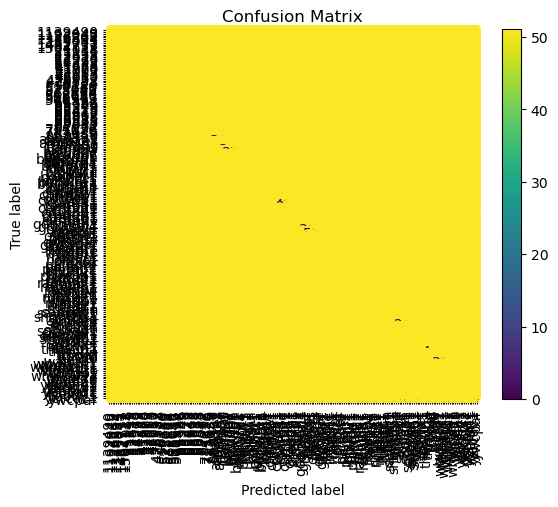

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
plt.figure(figsize=(12, 6))
disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [87]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     1192948       1.00      1.00      1.00         1
     1194042       0.00      0.00      0.00         1
      126247       0.00      0.00      0.00         1
     1346504       0.00      0.00      0.00         1
      134933       1.00      1.00      1.00         1
      135045       0.67      1.00      0.80         2
     1462711       0.00      0.00      0.00         1
     1462737       0.00      0.00      0.00         1
     1564122       0.20      1.00      0.33         1
       21211       0.56      0.67      0.61        15
       22333       0.50      0.44      0.47         9
       22973       0.31      0.36      0.33        11
       22976       0.11      0.11      0.11         9
       24272       0.00      0.00      0.00         1
       24292       1.00      1.00      1.00         1
       24322       0.00      0.00      0.00         3
       41663       0.38      0.36      0.37        22
       41970       1.00    

C:\Users\jayas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jayas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jayas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jayas\anaconda3\Lib\site-packages\sklea

In [89]:
import pandas as pd

# Hitung frekuensi label di test set
label_counts = pd.Series(y_test).value_counts()

# Tampilkan 10 label terbanyak
print(label_counts.head(10))

primary_label
grekis     198
compau     162
trokin     158
roahaw     142
banana     122
whtdov     115
socfly1    109
yeofly1    105
bobfly1    103
wbwwre1    100
Name: count, dtype: int64


In [44]:
top_labels = label_counts.head(10).index

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Filter hanya untuk top labels
mask = y_test.isin(top_labels)
cm = confusion_matrix(y_test[mask], pd.Series(y_pred)[mask], labels=top_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top_labels)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Top 10 Labels")
plt.show()

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

<Figure size 1000x800 with 0 Axes>

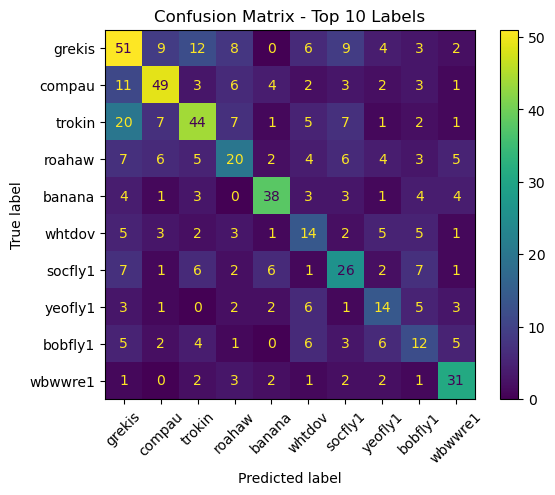

In [91]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


y_test_series = pd.Series(y_test).reset_index(drop=True)
y_pred_series = pd.Series(y_pred).reset_index(drop=True)
label_counts = y_test_series.value_counts()
top_labels = label_counts.head(10).index
mask = y_test_series.isin(top_labels)
y_test_filtered = y_test_series[mask].reset_index(drop=True)
y_pred_filtered = y_pred_series[mask].reset_index(drop=True)
cm = confusion_matrix(y_test_filtered, y_pred_filtered, labels=top_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top_labels)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Top 10 Labels")
plt.show()

## Hyperparameter Optuna

In [45]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train, y_train)
y_pred_baseline = rf_baseline.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

print(f"Baseline Accuracy (tanpa Optuna): {baseline_accuracy:.4f}")

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best trial parameters:", study.best_params)

best_params = study.best_params
rf_optimized = RandomForestClassifier(**best_params, random_state=42)
rf_optimized.fit(X_train, y_train)
y_pred_optimized = rf_optimized.predict(X_test)
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)

print(f"Optimized Accuracy (dengan Optuna): {optimized_accuracy:.4f}")

if optimized_accuracy > baseline_accuracy:
    print("Model dengan Optuna lebih baik dari baseline.")
else:
    print("Model baseline lebih baik dari model dengan Optuna.")

[I 2025-04-21 14:26:32,943] A new study created in memory with name: no-name-f9361395-eded-499d-84b9-14692cd00c56


Baseline Accuracy (tanpa Optuna): 0.1410


[I 2025-04-21 14:26:49,923] Trial 0 finished with value: 0.1339155749636099 and parameters: {'n_estimators': 93, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.1339155749636099.
[I 2025-04-21 14:27:14,114] Trial 1 finished with value: 0.13973799126637554 and parameters: {'n_estimators': 78, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.13973799126637554.
[I 2025-04-21 14:27:41,610] Trial 2 finished with value: 0.12615235322658905 and parameters: {'n_estimators': 151, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.13973799126637554.
[I 2025-04-21 14:28:34,466] Trial 3 finished with value: 0.1358563803978651 and parameters: {'n_estimators': 274, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.13973799126637554.
[I 2025-04-21 14:29:25,814] Trial 4 finished with value: 0.13998059194565746 and param

Best trial parameters: {'n_estimators': 182, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 1}
Optimized Accuracy (dengan Optuna): 0.1572
Model dengan Optuna lebih baik dari baseline.


##### jadi dari hasil parameter tuning diatas dapat dilihat bahwa menggunakan optuna lebih baik dibandingkan dengan metode sebelumnya.

In [40]:
features = []
labels = []

for i, row in tqdm(df_clean.iterrows(), total=len(df_clean)):
    path = os.path.join(audio_base_path, row["filename"])
    mfcc = extract_mfcc(path)
    if mfcc is not None:
        features.append(mfcc)
        labels.append(row["common_name"])

X = np.array(features)
y = np.array(labels)

100%|████████████████████████████████████████████████████████████████████████████| 20616/20616 [07:46<00:00, 44.21it/s]


In [44]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42
)

In [42]:
import pandas as pd
import numpy as np

label_counts = pd.Series(y).value_counts()
valid_labels = label_counts[label_counts >= 2].index
mask = pd.Series(y).isin(valid_labels)
X = X[mask]
y = np.array(y)[mask]

In [43]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42
)

## Unguided Datmod Week 10

C:\Users\ardo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ardo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


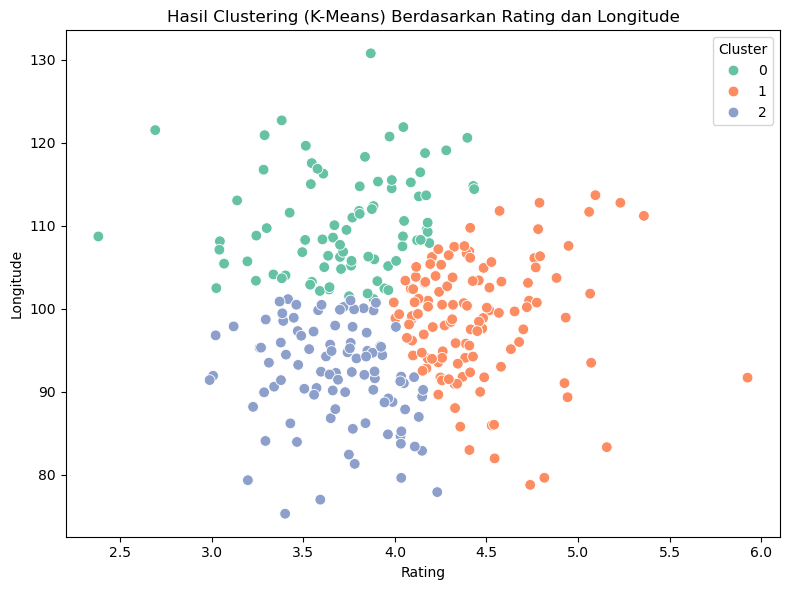

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

np.random.seed(42)
sample_size = 300
rating = np.random.normal(loc=4, scale=0.5, size=sample_size)
longitude = np.random.normal(loc=100, scale=10, size=sample_size)

df_cluster = pd.DataFrame({
    'rating': rating,
    'longitude': longitude
})
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_cluster[['rating', 'longitude']])

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
df_cluster['cluster'] = clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cluster, x='rating', y='longitude', hue='cluster', palette='Set2', s=60)
plt.title("Hasil Clustering (K-Means) Berdasarkan Rating dan Longitude")
plt.xlabel("Rating")
plt.ylabel("Longitude")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\ardo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ardo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ardo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ardo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ardo\anaconda3\Lib\site-packages\sklearn\cluster\_k

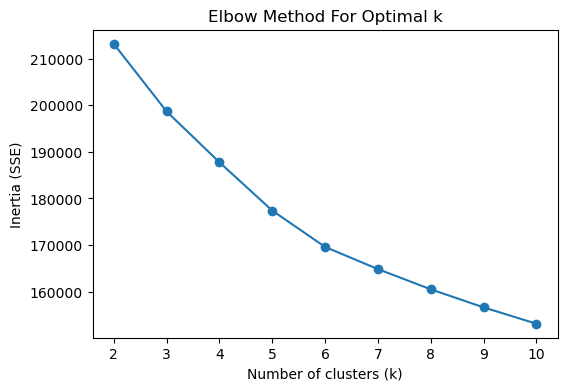

In [10]:
#scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#optima-k dgn elbow method
sse = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    sse.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method For Optimal k')
plt.show()

C:\Users\ardo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ardo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ardo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ardo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ardo\anaconda3\Lib\site-packages\sklearn\cluster\_k

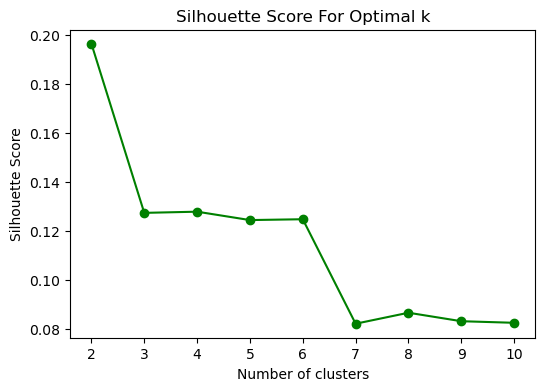

In [11]:
#silhoutte
silhouette_scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

C:\Users\ardo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


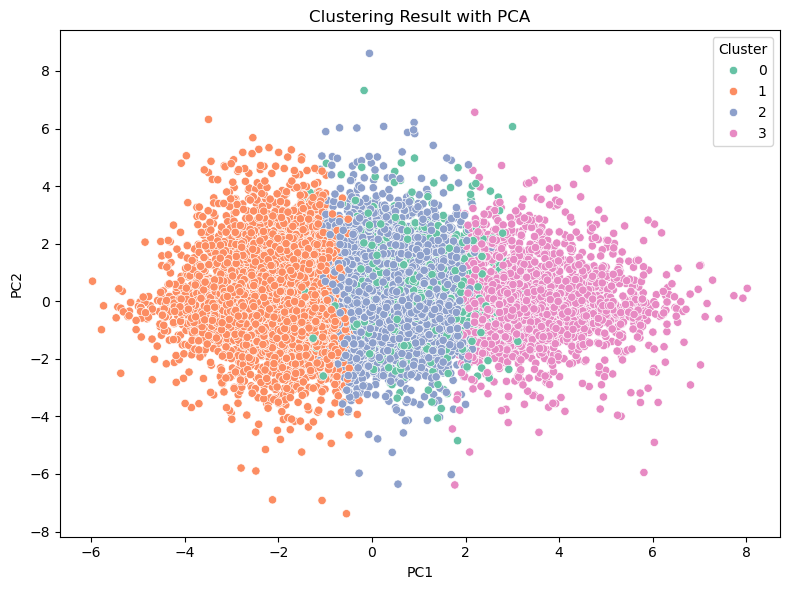

In [12]:
#clustering
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='Set2')
plt.title('Clustering Result with PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()